# Exploratory Data Analysis (EDA) - clustering of NYC map 
---
* **Overview default data**
<br />Use [train.csv](../data/train.csv) to do analysis, containing $1\,458\,644$ trips.

| Name | Description | type | unit |
| :----: | :---- | :----: | :----: | 
| id | a unique identifier for each trip | object |  |
| vendor_id | a code indicating the provider associated with the trip record | int | |
| pickup_datetime | date and time when the meter was engaged | object | |
| dropoff_datetime | date and time when the meter was disengaged (not in test data)| object | |
| passenger_count | the number of passengers in the vehicle (driver entered value) | int | people |
| pickup_longitude | the longitude where the meter was engaged | float | degree |
| pickup_latitude | the latitude where the meter was engaged | float | degree |
| dropoff_longitude | the longitude where the meter was disengaged | float | degree | 
| dropoff_latitude | the latitude where the meter was disengaged | float | degree |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip | object | |
| trip_duration | duration of the trip | int | second |

---
## Import modules & function defination

In [1]:
import re, calendar, time, datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string

---
## Class & function defination 

In [2]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, cmapn='winter', resolution=0.0001):
    ### setup marker generator and color map

    plt.clf()
    cmap = plt.get_cmap(cmapn)

    ### plot the decision suface
    # extract the minimum of 0 colume-variable & expand with 1 cm
    x1_min, x2_min = X[:, 0].min()-0.1, X[:, 1].min()-0.1
    x1_max, x2_max = X[:, 0].max()+0.1, X[:, 1].max()+0.1

    # Making a grid 2-D suface w.r.t. the resolution
    xx1, xx2 = np.meshgrid( np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))

    grid = np.array([xx1.ravel(), xx2.ravel()]).T
    Z  = classifier.predict(grid)
    Z_ = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z_, alpha=0.4, cmap=cmap)
    plt.xlim(x1_min, xx1.max())
    plt.ylim(x2_min, xx2.max())
    
    for c1 in np.unique(y):
        x1 = np.average(grid[(Z == c1), 0 ])
        x2 = np.average(grid[(Z == c1), 1 ])
        plt.text(x1, x2, str(c1), fontsize=8)
    
    # plot class samples
    #for idx, c1 in enumerate(np.unique(y)):
    #    plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1], c=cmap(idx), s=5, alpha=0.3 ) #c=colors(idx)


In [3]:
def draw_map_zone( df, x_name, y_name, z_name, name, zoom=0.9 ):

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]
    
    zones = np.unique(z)

    cutmap = zoom/100
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)

    #cmap = plt.get_cmap('spectral') 
    cmap = plt.get_cmap('winter') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(zones))]

    for i, zone in enumerate(zones):       
        plt.scatter( x=x[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     y=y[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     s=5, alpha=0.3, c=colors[i])

    plt.tick_params(labelsize=18)
    plt.title(name, fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)
    
def draw_sub_zone( data, marker='*' ):
    x=data['longitude']
    y=data['latitude']
    z=data['zone']
    
    zones = np.unique(z)
    
    cmap = plt.get_cmap('spring') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(zones))]
 
    for i, zone in enumerate(zones):       
        plt.scatter( x=x[ z==zone ], 
                     y=y[ z==zone ], 
                     c=colors[i], marker=marker)


---
## Load data & extract variables
### Load train data

In [4]:
df = pd.read_csv('../data/train.csv')
df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


### Load subway data

In [5]:
df_sub = pd.read_csv('../data/NYC_Subway_Stations_xml.csv')
df_sub.head(2)

,latitude,longitude,stop,sublines,substopid
0,40.799494,-73.968308,103rd St,1,22
1,40.790697,-73.947472,103rd St,6,120


### Define used variables

In [6]:
def selector_InOutlier_1D( df, column_name, outlier_percent=0.5, get_inlier=True ):
    ratio = outlier_percent/100. 
    if get_inlier:
        df_ = df[ (df[column_name] < df[column_name].quantile(1-ratio)) &
                  (df[column_name] > df[column_name].quantile(ratio)) ]
    else:
        df_ = df[ (df[column_name] >= df[column_name].quantile(1-ratio)) |
                  (df[column_name] <= df[column_name].quantile(ratio))]
    return df_

def selector_InOutlier_2D( df, column_name1, column_name2, outlier_percent=0.5, get_inlier=True ):
    ratio = outlier_percent/100. 
    if get_inlier:
        # Can not use double selector_InOutlier_1D to get, since quantile is w.r.t. datasize
        df_ = df[ (df[column_name1] < df[column_name1].quantile(1-ratio)) &
                  (df[column_name1] > df[column_name1].quantile(ratio))   &
                  (df[column_name2] < df[column_name2].quantile(1-ratio)) &
                  (df[column_name2] > df[column_name2].quantile(ratio))   ]
        
    else:
        df_ = df[ (df[column_name1] >= df[column_name1].quantile(1-ratio)) |
                  (df[column_name1] <= df[column_name1].quantile(ratio))   |
                  (df[column_name2] >= df[column_name2].quantile(1-ratio)) |
                  (df[column_name2] <= df[column_name2].quantile(ratio))   ]
    return df_

In [7]:
zoom = 0.5 # in percent
cutmap = zoom/100 
df_pick_in  = selector_InOutlier_2D( df, column_name1='pickup_longitude', column_name2='pickup_latitude')
df_pick_out = selector_InOutlier_2D( df, column_name1='pickup_longitude', column_name2='pickup_latitude', get_inlier=False )
df_drop_in  = selector_InOutlier_2D( df, column_name1='dropoff_longitude', column_name2='dropoff_latitude')
df_drop_out = selector_InOutlier_2D( df, column_name1='dropoff_longitude', column_name2='dropoff_latitude', get_inlier=False )

print 'Pickup'
print '- Inlier  : %d trips '% len(df_pick_in)
print '- Outlier : %d trips '% len(df_pick_out)
print 'Dropoff'
print '- Inlier  : %d trips '% len(df_drop_in)
print '- Outlier : %d trips '% len(df_drop_out)

Pickup
- Inlier  : 1429825 trips 
- Outlier : 28819 trips 
Dropoff
- Inlier  : 1431910 trips 
- Outlier : 26734 trips 


---
## Analysis
### 1. Heatmaps
**1.1 Trips **

In [8]:
def trip_density_map( x, y, bins=50, margin=0.02, cmap='hot', alpha=0.85, title='', debug=True, **hist2d_kwds):
    xmin, xmax, ymin, ymax = min(x), max(x), min(y), max(y)
    counts, xedges, yedges, image = plt.hist2d( x=x, 
                                                y=y,  
                                                range=[[xmin-margin, xmax+margin], 
                                                       [ymin-margin, ymax+margin]],
                                                bins=bins, 
                                                cmap=cmap, 
                                                alpha=alpha, 
                                                **hist2d_kwds)
    plt.colorbar(image)
    plt.tick_params(labelsize=20)
    plt.title(title, fontsize=25)
    plt.xlabel('Longitude', fontsize=25)
    plt.ylabel('Latitude', fontsize=25)
    
    if debug:
        print 'Total  : %d trips'% np.sum(counts)
        print '%d zones has non-zero density'% len(counts[ counts != 0 ])
        print 'Highest density :',np.max(counts)
    
    # counts - dims (2d) = xbins X ybins
    # xedges - dims (1d) = xbins + 1
    # yedges - dims (1d) = ybins + 1
    data = { 'trips' : counts.ravel().astype(int),
             'x1' : np.repeat(xedges[:-1],  len(counts)),
             'x2' : np.repeat(xedges[1:], len(counts)),
             'y1' : np.repeat(yedges[:-1],  len(counts)),
             'y2' : np.repeat(yedges[1:], len(counts)) }

    return pd.DataFrame(data=data)

Total  : 1429825 trips
1227 zones has non-zero density
Highest density : 30462.0


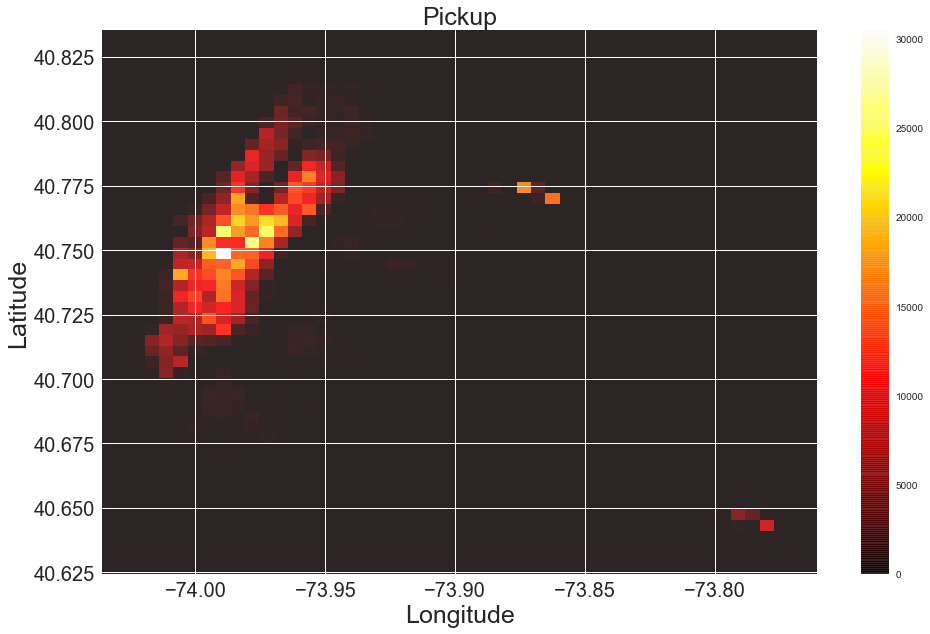

In [9]:
plt.figure(figsize=(16,10))
x_pick_in, y_pick_in = df_pick_in['pickup_longitude'].values, df_pick_in['pickup_latitude'].values
pick_density = trip_density_map(x_pick_in, y_pick_in, title='Pickup')
plt.show()

In [10]:
pick_density = pick_density[ pick_density['trips'] > 0 ].sort_values(['trips'], ascending=False )
pick_density.head(10)

,trips,x1,x2,y1,y2
429,30462,-73.991784,-73.986287,40.658160,40.662380
530,26512,-73.980790,-73.975292,40.666600,40.670819
431,25494,-73.991784,-73.986287,40.658160,40.662380
581,25014,-73.975292,-73.969795,40.670819,40.675039
582,21261,-73.975292,-73.969795,40.670819,40.675039
482,20653,-73.986287,-73.980790,40.662380,40.666600
632,19259,-73.969795,-73.964298,40.675039,40.679259
379,19137,-73.997281,-73.991784,40.653940,40.658160
277,18436,-74.008276,-74.002779,40.645501,40.649720
478,18101,-73.986287,-73.980790,40.662380,40.666600


Total  : 1431910 trips
1572 zones has non-zero density
Highest density : 34126.0


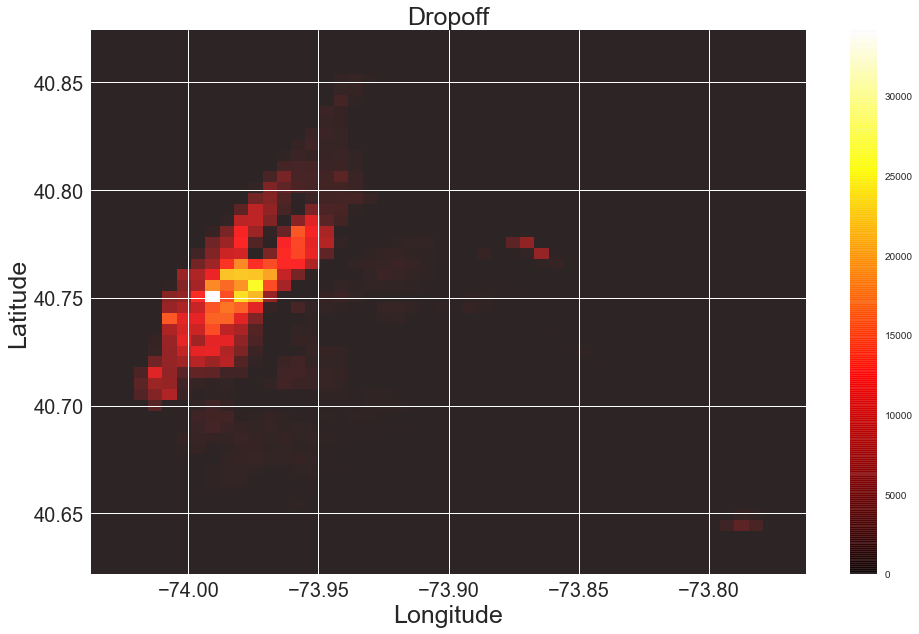

In [11]:
plt.figure(figsize=(16,10))
x_drop_in, y_drop_in = df_drop_in['dropoff_longitude'].values, df_drop_in['dropoff_latitude'].values
drop_density = trip_density_map(x_drop_in, y_drop_in, title='Dropoff')
plt.show()

In [12]:
drop_density = drop_density[ drop_density['trips'] > 0 ].sort_values(['trips'], ascending=False )
drop_density.head(10)

,trips,x1,x2,y1,y2
425,34126,-73.993340,-73.987853,40.662277,40.667322
576,25514,-73.976879,-73.971392,40.677411,40.682456
525,23857,-73.982366,-73.976879,40.672367,40.677411
527,22491,-73.982366,-73.976879,40.672367,40.677411
577,22142,-73.976879,-73.971392,40.677411,40.682456
477,22021,-73.987853,-73.982366,40.667322,40.672367
575,21411,-73.976879,-73.971392,40.677411,40.682456
627,20197,-73.971392,-73.965905,40.682456,40.687501
526,19289,-73.982366,-73.976879,40.672367,40.677411
528,18626,-73.982366,-73.976879,40.672367,40.677411


* Pickup & dropoff have similar behavior of density. Highest density is between **-73.993 - -73.986** & **40.658 - 40.667** of **NYC downtown**.
* The other significant region has visible density is in **La Guardia** & **Airport**

### 2. Clustering

In [13]:
from sklearn.cluster import *

In [14]:
class cluster_zone(object):
    def __init__(self, df, n_zone=100):
        self.df = df
        self.X = self.df.values
        self.n_sample  = self.X.shape[0]
        self.n_feature = self.X.shape[1]
        self.n_zone = n_zone
        ## Cluster_Name : [ used, class, use_n_sample, time ]
        self.cluster = {'kmeans'     : [ False, MiniBatchKMeans(),         0, 0], 
                        'wardAgg'    : [ False, AgglomerativeClustering(), 0, 0],
                        'completeAgg': [ False, AgglomerativeClustering(), 0, 0]}
    
    def shuffel(self, use_sample=None, random_state=1):
        np.random.seed(random_state)
        return self.df.reindex(np.random.permutation(self.df.index)).values[:use_sample]
        
    def fit(self, name, use_sample=None, debug=False, random_state=1):
        start_time = time.time()
        self.cluster[name][0] = True
        self.cluster[name][1].fit(self.shuffel(use_sample=use_sample, 
                                               random_state=random_state))
        self.cluster[name][2] = use_sample
        self.cluster[name][3] = time.time() - start_time
        if debug:
            print 'Used %.2f sec. (%.0f)'%( self.cluster[name][3], self.cluster[name][2])
            
    def predict(self, name, X):
        #if name not in self.cluster: return
        if name != 'kmeans': return
        return self.cluster[name][1].predict(X)
    
    def predict_df_column(self, algo_name, df_predict ):
        return pd.DataFrame(self.predict(algo_name, df_predict.values))

    def kmeans(self, use_sample=500000, batch_size=10000, random_state=1, debug=False ):
        self.cluster['kmeans'][1] = MiniBatchKMeans( n_clusters = self.n_zone, 
                                                     batch_size = batch_size, 
                                                     random_state = random_state)
        self.fit('kmeans', use_sample, debug)
        
    def wardAgg(self, use_sample=20000, debug=False):
        self.cluster['wardAgg'][1] = AgglomerativeClustering( n_clusters=self.n_zone, linkage='ward')
        self.fit('wardAgg', use_sample, debug)
        
    def completeAgg(self, use_sample=20000, debug=False):
        self.cluster['completeAgg'][1] = AgglomerativeClustering( n_clusters=self.n_zone, linkage='complete')
        self.fit('completeAgg', use_sample, debug)
    

In [15]:
df_map = df[['pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']]
pick_train = df_map[['pickup_longitude','pickup_latitude']]
drop_train = df_map[['dropoff_longitude','dropoff_latitude']]
train_sample = pd.DataFrame(np.vstack((pick_train.values, drop_train.values)), 
                            columns=['longitude','latitude'])
train_sample.head()

,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209


In [16]:
clusters = cluster_zone( train_sample )
clusters.df.head()

,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209


In [17]:
clusters.X

array([[-73.98215485,  40.76793671],
       [-73.98041534,  40.73856354],
       [-73.97902679,  40.7639389 ],
       ..., 
       [-74.00443268,  40.70737076],
       [-73.97463226,  40.75710678],
       [-73.97280884,  40.79058456]])

In [18]:
print len(clusters.df), len(clusters.X)

2917288 2917288


In [19]:
clusters.kmeans(debug=True)

Used 2.70 sec. (500000)


In [20]:
clusters.wardAgg(debug=True)

Used 15.48 sec. (20000)


In [21]:
clusters.completeAgg(debug=True)

Used 14.75 sec. (20000)


In [25]:
df_map['pickup_zone']  = clusters.predict_df_column('kmeans', pick_train)
df_map['dropoff_zone'] = clusters.predict_df_column('kmeans', drop_train)
df_map.head()

/Users/Alpha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Alpha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_kmeans,dropoff_kmeans,pickup_zone,dropoff_zone
0,-73.982155,40.767937,-73.964630,40.765602,46,24,46,24
1,-73.980415,40.738564,-73.999481,40.731152,94,13,94,13
2,-73.979027,40.763939,-74.005333,40.710087,43,11,43,11
3,-74.010040,40.719971,-74.012268,40.706718,28,8,28,8
4,-73.973053,40.793209,-73.972923,40.782520,35,98,35,98


In [24]:
## mix up all coordinate records
#useData=500000
#batch_size=10000
#n_zone=100
#coords = np.vstack((pick_train.values, drop_train.values))

#np.random.seed(1)
#sample_ind = np.random.permutation(len(coords))[:useData]
#kmeans = MiniBatchKMeans(n_clusters=n_zone, batch_size=batch_size, random_state=1).fit(coords[sample_ind])

In [ ]:
#df_map.loc[:, 'pickup_zone']  = pd.Series(kmeans.predict(pick_train.values),  index=df_map.index)
#df_map.loc[:, 'dropoff_zone'] = pd.Series(kmeans.predict(drop_train.values),  index=df_map.index)
#df_map.head()

In [ ]:
#df_sub.loc[:, 'zone']  = kmeans.predict(df_sub[['longitude', 'latitude']])
#df_sub.head()

In [26]:
z_pick, z_drop = df_map['pickup_zone'].values, df_map['dropoff_zone'].values,
#z_sub = df_sub['zone'].values
np.unique(z_pick)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int32)

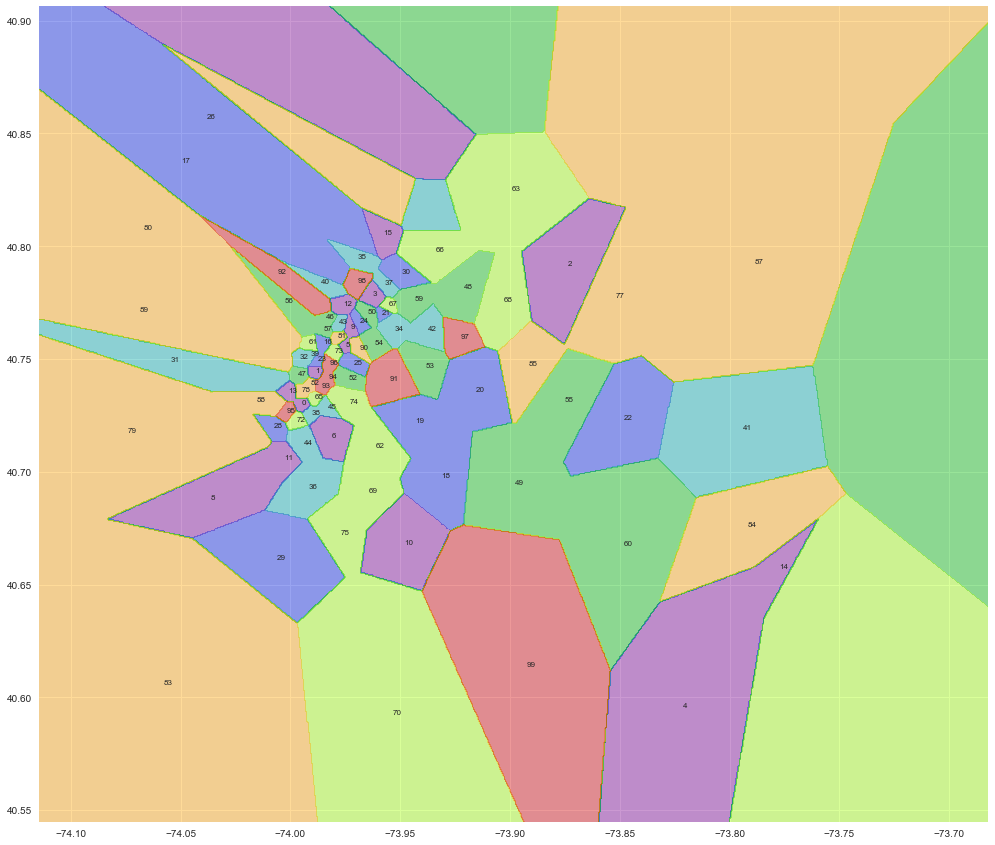

In [27]:
cutmap = 1./100.
df_ = df_map[ (df_map['pickup_longitude'] < df_map['pickup_longitude'].quantile(1-cutmap)) & 
              (df_map['pickup_longitude'] > df_map['pickup_longitude'].quantile(cutmap))   & 
              (df_map['pickup_latitude']  < df_map['pickup_latitude'].quantile(1-cutmap))  &  
              (df_map['pickup_latitude']  > df_map['pickup_latitude'].quantile(cutmap))  ]

x1, x2, y = df_[['pickup_longitude']].values, df_[['pickup_latitude']].values, df_['pickup_zone'].values
X = np.hstack((x1, x2))

plt.figure(figsize=(17,15))
plot_decision_regions( X, y, kmeans, cmapn='nipy_spectral', resolution=0.0005 )
#draw_sub_zone(df_subway)
plt.show()

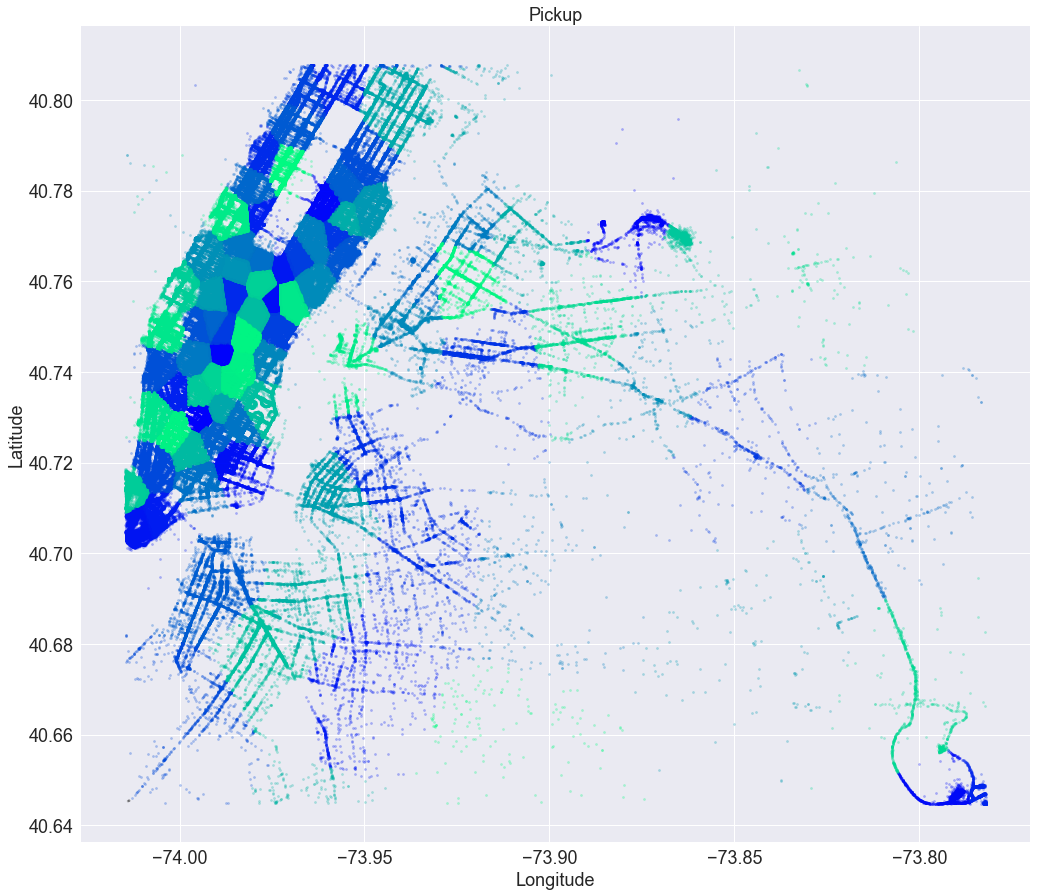

In [28]:
plt.figure(figsize=(17,15))
draw_map_zone(df_map, 'pickup_longitude', 'pickup_latitude', 'pickup_zone', 'Pickup')
#draw_sub_zone(df_sub)
plt.show()

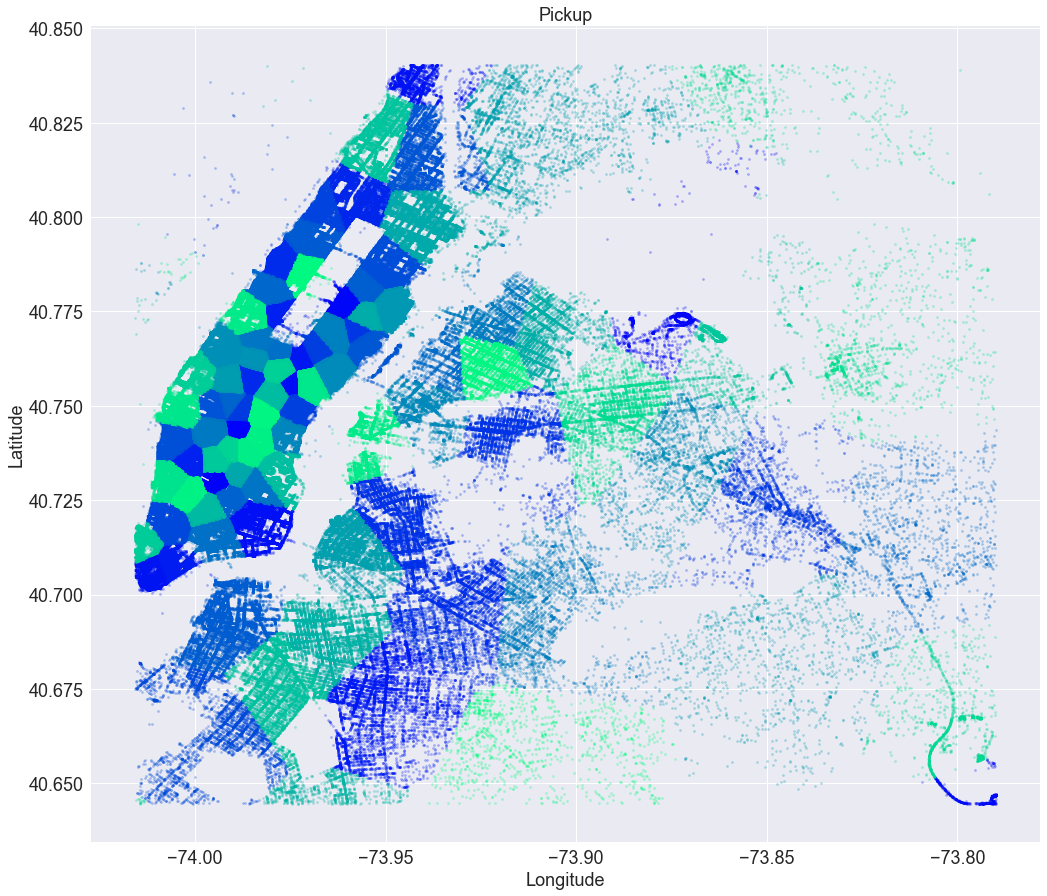

In [29]:
plt.figure(figsize=(17,15))
draw_map_zone(df_map, 'dropoff_longitude', 'dropoff_latitude', 'dropoff_zone', 'Pickup')
#draw_sub_zone(df_sub)
plt.show()